In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch
import datetime
import pickle
import functions
import os

In [2]:


# set device
dtype = torch.float
cpu = torch.device("cpu")
gpu = torch.device("cuda:0")

device = cpu
# Uncomment the line below to run on GPU
#device = gpu

args = {'thres': -50,
        'u_rest': -60,
        'tau_mem': 1e-2,
        'tau_syn': 5e-3,
        'tau_ref': 5e-3,
        'tau_het': 5e-3, # regulation term time constant (pure guess)
        't_rise': 5e-3, # the pre-synaptic double exponential kernel rise time
        't_decay': 1e-2, # the pre-synaptic double exponential kernel decay time
        'timestep_size': 1e-4, # 0.1 msec
        't_rise_alpha': 5e-3, # change this
        't_decay_alpha': 1e-2, # change this 
        'nb_steps': 5000, # 0.5 secs in total
        'tau_rms': 5e-4,
        'nb_inputs': 100,
        'nb_hidden': 4,
        'nb_outputs': 1,
        'nb_epochs': 15,
        'rho': 1, # regularization strength
        'a': 4, # exponent parameter for regularization evaluation
        'epsilon': 1e-4
        } 
    
args['device'] = device
args['dtype'] = dtype
nb_inputs = args['nb_inputs']
nb_hidden = args['nb_hidden']
nb_outputs = args['nb_outputs']

nb_steps = args['nb_steps']
nb_epochs = args['nb_epochs']
dt = args['timestep_size']

tau_syn = args['tau_syn']
tau_mem = args['tau_mem']

alpha = np.exp(-dt/tau_syn)
beta = np.exp(-dt/tau_mem)

args['alpha'] = alpha
args['beta'] = beta

nb_trials = 1

# 100 independent poisson trains
spk_freq = 10
input_trains = functions.poisson_trains(nb_inputs, spk_freq*np.ones(nb_inputs), args)

# 5 equidistant spikes over 500 msec.
target = torch.zeros((nb_steps), device=device, dtype=dtype)
target[500::int(nb_steps/5)] = 1

#@title Training the network

#weight_scale = 100

#w1, w2 = functions.initialize_weights_multilayer(nb_inputs, nb_hidden, nb_outputs, args, weight_scale)

w1, w2 = functions.new_initialize_weights_multilayer(nb_inputs, nb_hidden, nb_outputs, args) #shape: (nb_inputs, nb_hidden), (nb_hidden, nb_outputs)

#feedback_weights = functions.random_feedback(nb_hidden, nb_outputs, args).T # shape: (nb_outputs, nb_hidden)

# Symmetric Feedback
feedback_weights = w2.T
gamma = float(np.exp(-dt/args['tau_rms']))

#learning_rates = np.array([50, 5, 1, 10, 0.5, 0.1]) * 1e-3
learning_rates = np.array([50])*1e-3

for r_0 in learning_rates:
  print("Learning rate =", r_0)
  
#  loss_rec = torch.empty((nb_trials, nb_epochs), device=device, dtype=dtype)
  loss_rec = np.empty((nb_trials, nb_epochs))
  recordings_list = []

  for i in range(nb_trials):

    new_w1, new_w2, loss_rec[i], recordings = functions.train_multilayer_network(input_trains, w1, w2, feedback_weights, target, r_0, args)
    recordings_list.append(recordings)  
    plt.plot(loss_rec[i], alpha=0.5)

  plt.plot(np.mean(loss_rec, axis=0), color='black', label='Avg. Loss')
  plt.title("Loss over epochs, learning rate = " + str(r_0))
  plt.legend()
  # plt.show()

#   data_folder = "data/multilayer/" + \
#         str(datetime.datetime.today())[:13] + ' rate = ' + str(r_0) + '/'
#   location = os.path.abspath(data_folder)
#   location = os.path.join(os.getcwd(), location)
#   os.makedirs(location)

#   plt.savefig(location + "/loss over epochs" + "learning-rate = " + str(r_0) +
#               ", epsilon = " + str(args['epsilon']) + "spike freq = " + str(spk_freq) + ".jpg")

#   loss_file_name = location + "/loss_rec epsilon= " + \
#       str(args['epsilon']) + "learning_rate = " + \
#       str(r_0) + "spike freq = " + str(spk_freq)
#   loss_file = open(loss_file_name, 'wb')
#   pickle.dump(loss_rec, loss_file)
#   loss_file.close()

#   # Store args:
#   file_name = location + "/args epsilon = " + \
#       str(args['epsilon']) + " learning_rate = " + \
#       str(r_0) + " spike freq = " + str(spk_freq)
#   args_file = open(file_name, 'a')
#   args_file.write(str(args))
#   args_file.close()

#   recordings_filename = location + "/recordings epsilon= " + \
#         str(args['epsilon']) + "learning_rate = " + \
#         str(r_0) + "spike freq = " + str(spk_freq)

#   recordings_file = open(recordings_filename, 'wb')
#   pickle.dump(recordings_list, recordings_file)
#   recordings_file.close()



  0%|          | 0/15 [00:00<?, ?it/s]

Learning rate = 0.05
Epoch no: 0
Loss = tensor(166.6818)


IndexError: too many indices for tensor of dimension 2

In [8]:
args, neural_dynamics, weight_dynamics, learning_rate_dynamics = recordings
spk_rec_1, spk_rec_2, mem_rec_1, mem_rec_2, presynaptic_traces_1, presynaptic_traces_2, eligibility_1, eligibility_2, output_error, feedback_error = neural_dynamics


In [11]:
args

{'thres': -50,
 'u_rest': -60,
 'tau_mem': 0.01,
 'tau_syn': 0.005,
 'tau_ref': 0.005,
 'tau_het': 0.005,
 't_rise': 0.005,
 't_decay': 0.01,
 'timestep_size': 0.0001,
 't_rise_alpha': 0.005,
 't_decay_alpha': 0.01,
 'nb_steps': 5000,
 'tau_rms': 0.0005,
 'nb_inputs': 100,
 'nb_hidden': 4,
 'nb_outputs': 1,
 'nb_epochs': 1,
 'rho': 1,
 'a': 4,
 'epsilon': 0.0001,
 'device': device(type='cpu'),
 'dtype': torch.float32,
 'alpha': 0.9801986733067553,
 'beta': 0.9900498337491681}

In [9]:
spk_rec_1

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

ValueError: operands could not be broadcast together with shapes (4,) (5000,) 

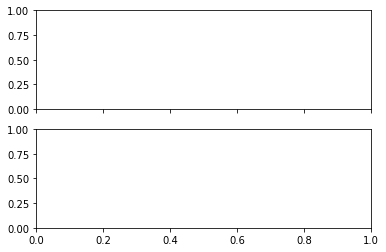

In [10]:
nb_steps = args['nb_steps']
nb_hidden = args['nb_hidden']
dt = args['timestep_size']
# Plot spk recordings of hidden and output layer in a single plot

fig, axs = plt.subplots(2, 1, sharex=True)

positions_1 = np.arange(0, nb_steps)
spike_positions_1 = positions[spk_rec_1 == 1]
axs[0].eventplot(spike_positions)
axs[0].set_title("Output Spike Train")
axs[0].set_xlim([0, nb_steps])



In [17]:

def plot_spike_trains(spike_trains, title='Spike Trains'):
    """
    """
    plt.figure(dpi = 100)
    for i in range(len(spike_trains)):
        positions = np.arange(0, nb_steps)
        spike_positions = positions[spike_trains[i] == 1]
        plt.eventplot(spike_positions, lineoffsets=i)
    plt.xlim(0, nb_steps)
    plt.title(title)
    plt.xlabel('Timestep')
    plt.ylabel('Spike Train No.')
    plt.show()


In [20]:
spk_rec_2

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])

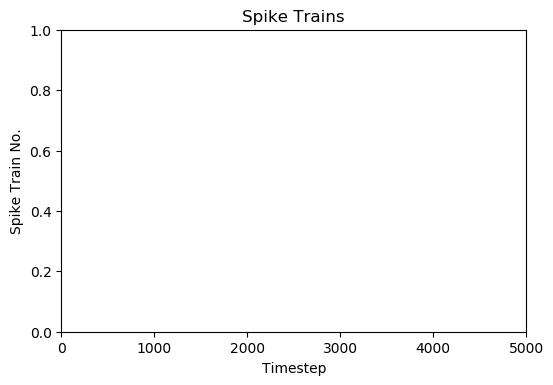

In [19]:
plot_spike_trains(spk_rec_2)